# Data scientist job market in the U.S.
This data set, which is publicly available on Kaggle, was generated by collecting information from the LinkedIn website about numerous data scientist jobs around the U.S. (August, 2018). The description mentions an especially accute shortage of professionals with data science skills in some areas like New York City, San Francisco and Los Angeles.

In this project I focused on data cleaning, exploration and visualization to further investigate and dilucidate the trends that the data science U.S. job market shows.



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-1.-Data-exploration-" data-toc-modified-id="-1.-Data-exploration--1"><span style="color: steelblue"> 1. Data exploration </span></a></span></li><li><span><a href="#-2.-Data-cleaning-" data-toc-modified-id="-2.-Data-cleaning--2"><span style="color: steelblue"> 2. Data cleaning </span></a></span></li><li><span><a href="#-3.-Exploratory-data-analysis-and-visualization-" data-toc-modified-id="-3.-Exploratory-data-analysis-and-visualization--3"><span style="color: steelblue"> 3. Exploratory data analysis and visualization </span></a></span></li></ul></div>

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## <span style='color:steelblue'> 1. Data exploration </span>

In [146]:
dsjobs = pd.read_csv("alldata.csv")

In [147]:
dsjobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6964 entries, 0 to 6963
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     6953 non-null   object 
 1   company      6953 non-null   object 
 2   description  6953 non-null   object 
 3   reviews      5326 non-null   float64
 4   location     6953 non-null   object 
dtypes: float64(1), object(4)
memory usage: 272.2+ KB


In [148]:
dsjobs.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [149]:
print(dsjobs.isnull().sum())

position         11
company          11
description      11
reviews        1638
location         11
dtype: int64


**Dataset description**
&nbsp;

The columns in the data set consist of the job position, the company name, the job description, number of reviews given to the company and the job location.

There are a total of 6953 rows and it can be observed that there are missing values in the 'reviews' column (which is the only float type) and there are 11 missing rows altogether.

There also seems to be some irregularities to fix in the 'location' column, since some locations contain a zip code and others do not.

In [150]:
dsjobs.describe(include='all').loc['unique', :]


position       5242
company        2213
description    6708
reviews         NaN
location        382
Name: unique, dtype: object

There are 5242 distinct job positions from 2213 different companies in 382 locations. 

## <span style='color:steelblue'> 2. Data cleaning </span>

To continue the data exploration and derive some insights from visualization, data cleaning was required.

First, the 11 rows with completely missing values were eliminated using the following code:

In [151]:
dsjobs = dsjobs[dsjobs['position'].notna()]

In [152]:
print(dsjobs.isnull().sum())

position          0
company           0
description       0
reviews        1627
location          0
dtype: int64


The rest of NaN values in the 'reviews' column was dealt with by using median imputation based on the reviews given by company (in cases where it was possible since some companies might not have had reviews at all).

It can be observed that at least some values were salvaged using this method.

In [153]:
dsjobs.fillna(dsjobs.groupby(['company'], 
              as_index=False).median(), 
              inplace=True)


In [154]:
print(dsjobs.isnull().sum())

position          0
company           0
description       0
reviews        1327
location          0
dtype: int64


The rest were left untouched for the moment, since they do not interfere with the categorical variables' analysis.

As previously mentioned, the location column requires some processing:

In [156]:
dsjobs['location'].value_counts()[:15].index.tolist()

['Seattle, WA',
 'New York, NY',
 'Cambridge, MA',
 'Boston, MA',
 'San Francisco, CA',
 'San Diego, CA',
 'Chicago, IL',
 'Boulder, CO',
 'Washington, DC',
 'Sunnyvale, CA',
 'Mountain View, CA',
 'Los Angeles, CA',
 'Austin, TX',
 'Atlanta, GA',
 'Redmond, WA 98052']

To homogenize it, the following code was run to extract and exclude the zip code (which in this case is not relevant for analysis) and to remove additional spaces.

In [157]:
dsjobs['location'] = dsjobs['location'].str.replace('\d+', '')

In [158]:
dsjobs['location'] = dsjobs['location'].str.replace(" ", "")

In [159]:
dsjobs['location'].value_counts()[:10].index.tolist() # verifying that it was fixed 

['NewYork,NY',
 'Seattle,WA',
 'Cambridge,MA',
 'Boston,MA',
 'SanFrancisco,CA',
 'Chicago,IL',
 'SanDiego,CA',
 'Washington,DC',
 'MountainView,CA',
 'Atlanta,GA']

Finally, the 'description' column text was all changed to lower case for easier string analysis.

In [160]:
dsjobs.description = dsjobs.description.str.lower()

In [162]:
dsjobs['description']

0       development director\nals therapy development ...
1       job description\n\n"the road that leads to acc...
2       growing company located in the atlanta, ga are...
3       department: program operationsposition locatio...
4       description\nthe emory university department o...
                              ...                        
6959    are you data-driven? we at netapp believe in t...
6960    pharmacyclics is committed to the development ...
6961    oath, a subsidiary of verizon, is a values-led...
6962    we are the bing core relevance team responsibl...
6963    comcast’s technology &amp; product organizatio...
Name: description, Length: 6953, dtype: object

## <span style='color:steelblue'> 3. Exploratory data analysis and visualization </span>

First, to investigate the top ten most frequent job positions in this data set, the following data frame was created:

In [163]:
top_positions = pd.DataFrame(dsjobs["position"].value_counts()[:10])
top_positions['index1'] = top_positions.index
top_positions.reset_index(drop=True, inplace=True)
top_positions.columns = ['count', 'Position']

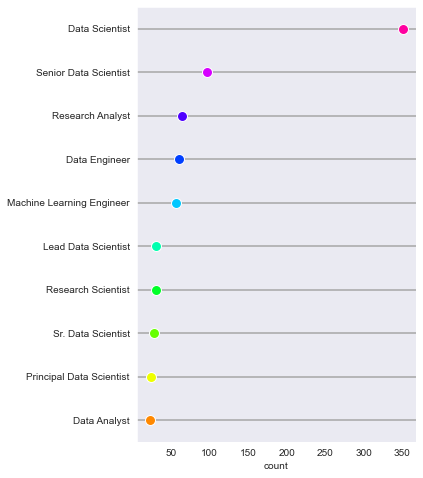

In [164]:
# Count plot of the top 10 most frequent job positions
sns.set_style("dark")
plt.figure(figsize = (5,8))

ax = sns.stripplot(x = "count", y = "Position", 
                                  data = top_positions, 
                                  palette = "hsv_r", size=10, 
                                  jitter=False, 
                                  linewidth=1, 
                                  edgecolor="w")

ax.yaxis.grid(True, color='0.65', ls='-', lw=1.5, zorder=0)
ax.set(ylabel='')
plt.show()

The plot above shows that besides the data scientist usual positions there is also a relatively abundant amount of research and data engineering jobs.

In the context of technology, usually the market's five most popular companies come to mind, so a data frame was created to show FAANG companies' jobs count, as well as the top ten companies with the highest number of job offers.

In [165]:
faang_data = {'Company' : ['Facebook', 'Amazon.com', 'Apple', 'Netflix', 'Google'],
           'count' :  [sum(dsjobs.company == 'Facebook'),
                          sum(dsjobs.company == 'Amazon.com'),
                          sum(dsjobs.company == 'Apple'),
                          sum(dsjobs.company == 'Netflix'),
                          sum(dsjobs.company == 'Google')]}
faang_companies = pd.DataFrame(faang_data, columns = ['Company', 'count'])

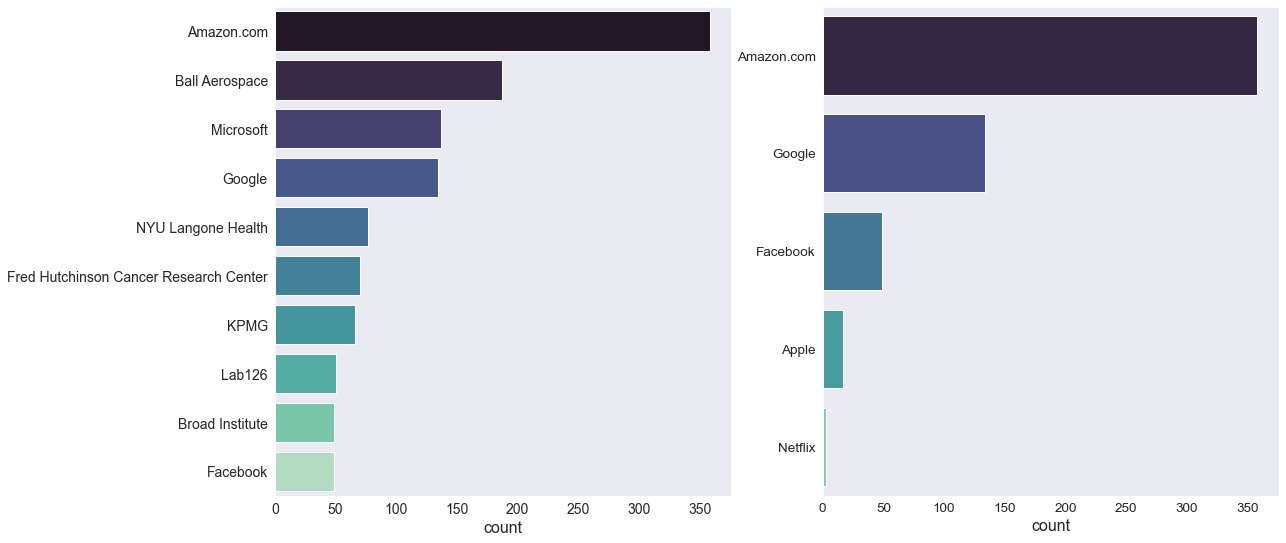

In [166]:
# Count plots of the top 10 companies with most job offers and FAANG companies 

plt.figure(figsize=(18,9))

with sns.axes_style("dark"):
    plt.subplot(121)
    ax = sns.countplot(y="company", 
                       data=dsjobs, 
                       order=dsjobs["company"].value_counts()[:10].index, 
                       palette="mako")
    
plt.subplot(122)
ax2 = sns.barplot(x = 'count',
                  y = "Company", 
                  data=faang_companies, 
                  order=faang_companies.sort_values('count',
                  ascending = False).Company, 
                  palette = "mako")

ax.set(ylabel='')
ax.tick_params(labelsize=14)
ax.set_xlabel("count", fontsize=16)
ax2.set(ylabel='')
ax2.tick_params(labelsize=13.5)
ax2.set_xlabel("count", fontsize=16)


plt.show()

It can be observed that most companies in the top ten are tech companies, although there are some other areas with significant presence, such as health and research, hardware development, legal and economic assessments.
In this case, out of all the FAANG companies, Amazon and Google offered most of the job positions.

To investigate the locations offering the most job positions, the following data frame was created: 

In [167]:
top_locations = pd.DataFrame(dsjobs["location"].value_counts()[:20])
top_locations['index1'] = top_locations.index
top_locations.reset_index(drop=True, inplace=True)
top_locations.columns = ['count', 'Location']
top_locations['percentage'] = (top_locations['count'] / 5242) * 100

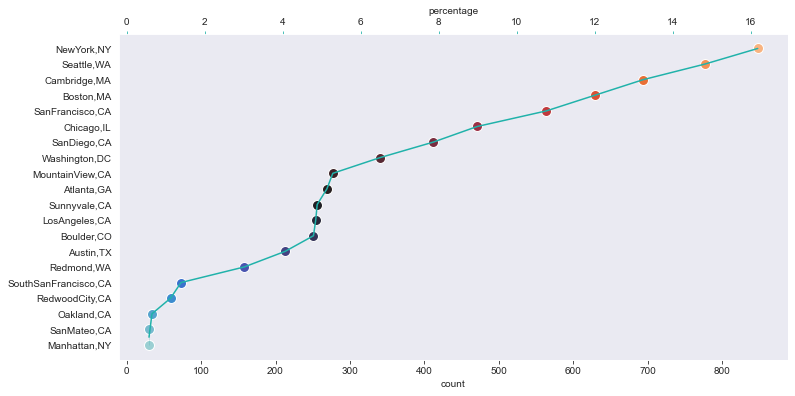

In [168]:
# Combo plot of locations with the most job offers, by count and percentage
sns.set_style("dark")

plt.figure(figsize = (12,6))

ax = sns.stripplot(x = "count",
                   y = "Location", 
                   data = top_locations, 
                   palette = "icefire_r", size=10, 
                   jitter=False, 
                   linewidth=1, 
                   edgecolor="w")
ax.set(ylabel='')

ax2 = ax.twiny()
color = 'lightseagreen'

ax2 = sns.lineplot(x='percentage', y='Location', data = top_locations, sort=False, color=color)
ax2.tick_params(axis='x', color=color)

plt.show()

The data confirmed the data set's description claims that there is high demand of data scientists in Ney York and California. However, there is also significant demand in other states like Washington, Massachussets, Georgia and Texas.  

To study the 'reviews' column the remaining NaN values were excluded using the following code:

In [169]:
dsjobs = dsjobs[dsjobs['reviews'].notna()]

A data frame of the top reviewed companies was created.

In [170]:
dsjobs.reviews.quantile(0.95) # 95th percentile

25902.0

In [171]:
top_reviewed = pd.DataFrame(dsjobs[dsjobs['reviews'] >= 25902])
top_reviewed = top_reviewed.sort_values(by='reviews', ascending=False)

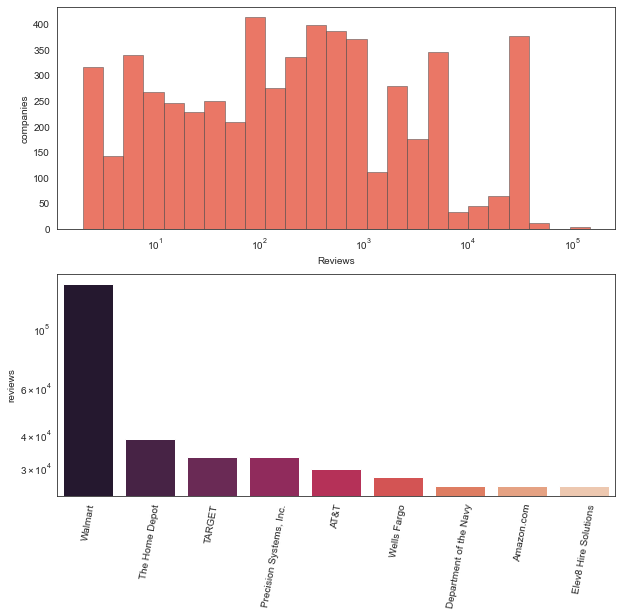

In [172]:
# Histogram of reviews by company and plot of top reviewed companies

plt.figure(figsize=(10,9))
sns.set_palette("RdYlGn")
sns.set_style("white")

with sns.axes_style("white"):
    plt.subplot(211)
    ax = sns.histplot(dsjobs, x = "reviews", multiple="stack", log_scale=True,
    edgecolor=".3", linewidth=.5,)


plt.subplot(212)
ax2 = sns.barplot(x = "company", y = "reviews", data = top_reviewed, palette = "rocket")


ax.set_xlabel('Reviews')
ax.set_ylabel('companies')
ax2.set_xticklabels(top_comp.get_xticklabels(), rotation=80)
ax2.set_xlabel('')
ax2.set_yscale("log")

plt.show()

It can be observed that the number of reviews per company is variable and not normally distributed. A prestigious and top job offering company like Amazon is highly reviewed, however, there are also other less renowned tech and miscellanous companies. Plus, it is not determined if the total of the reviews are positive or negative, thus, the relation between number of ratings and company quality and number of job positions is inconclusive.

Finally, a wordcloud was created to show the most important words contained in the text of the 'description' column.

In [173]:
text = " ".join(review for review in dsjobs.description)
print ("There are {} words in the description column.".format(len(text)))

There are 22310393 words in the description column.


In [174]:
stopwords = set(STOPWORDS) # set the stopwords

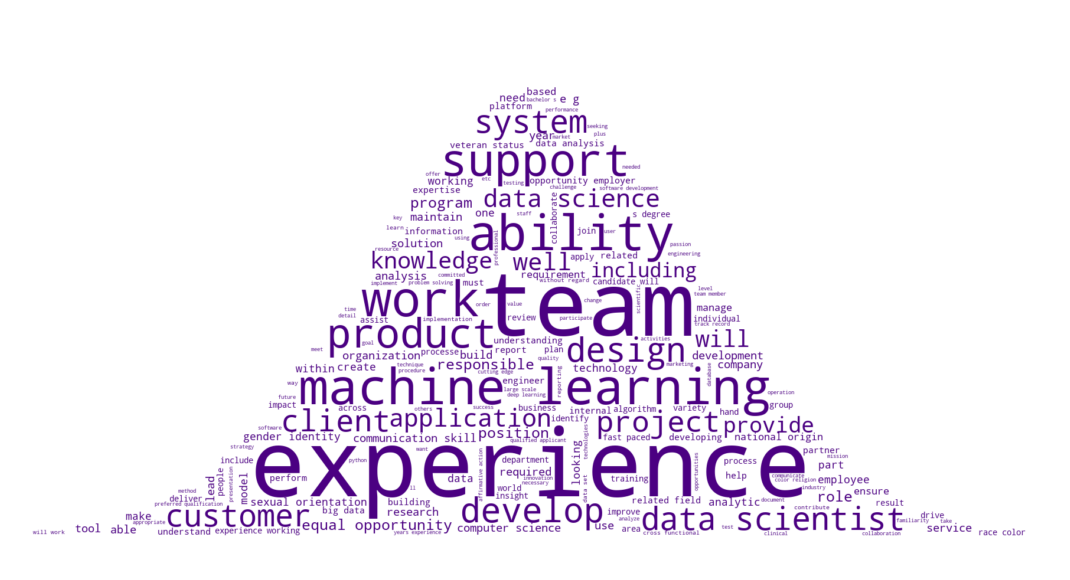

In [175]:
# Wordcloud of the most important words in the job description column

mask = np.array(Image.open("img/Bell.png"))
ax = WordCloud(background_color='white', mask=mask, mode='RGB',
               color_func=lambda *args, **kwargs: "indigo", 
               width=1000, max_words=200, height=1000,
              random_state=1, stopwords=stopwords)

ax.generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')

plt.show()